(60316,)
(4097, 30)


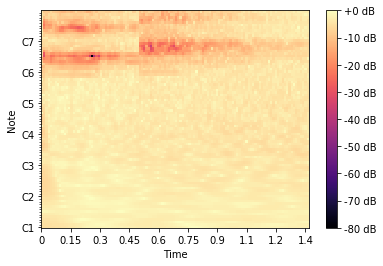

In [69]:
import librosa
import librosa.display
import numpy as np
from matplotlib import pyplot as plt
import soundfile
import scipy
from scipy.signal import medfilt, butter, lfilter, find_peaks
import pandas as pd
import math


def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a


def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

# sample rate
SR = 44100
# cos waves to simulate 
COSINE_WAVES = 10
# FFT function param
N_FFT = 8192
WIN_LEN = int(N_FFT)
HOP_LEN = int(WIN_LEN/4)
# frequency tracking param
FREQ_DELTA = 0.01
# length of each frame, must be an even number and be equal or larger to HOP_LEN
# if frame_len > hop_len, it means there is overlapping between frames
FRAME_LEN = int(2*HOP_LEN)

mp3_path = 'e:/Courses/mus270b/hw1/white_bellbird.wav'
y, sr = librosa.load(mp3_path,sr=SR)
print(y.shape)

stft = librosa.stft(y,hop_length=HOP_LEN, win_length=WIN_LEN, n_fft=N_FFT, center=True)
print(stft.shape) # freq bins(row) over frames(cols)
cqt = librosa.amplitude_to_db(np.abs(librosa.cqt(y, sr=sr)), ref=np.max)
librosa.display.specshow(librosa.amplitude_to_db(cqt, ref=np.max), sr=sr, x_axis='time', y_axis='cqt_note')
plt.colorbar(format='%+2.0f dB')
plt.show()



In [94]:
class Formant:
    def __init__(self,freq=0,mag=0,phi=0):
        self.freq = freq
        self.mag = mag
        self.phi = phi
    
    def __repr__(self):
        return str((self.freq,self.mag,self.phi))
    

# parabolic interpolation for complex number
# return ((x, y_real),(x, y_imag))
def bin_to_freq(bn):
    return bn * SR/N_FFT

def mag_to_sin(amp, phi):
    return 2*amp/np.abs(complex(math.cos(phi), math.sin(phi)))

# detect peak using parabolic interpolation
def peak_detection(frame):
    # find peaks by magnitude
    row = librosa.amplitude_to_db(np.abs(frame))
    peaks = find_peaks(row)[0]
    res = [None] * len(peaks)
    # phase
    phases = np.angle(frame)
    res = [None]*len(peaks)
    for i, x in enumerate(peaks):
        # parabolic for maglitude
        xv = 1/2 * (row[x-1] - row[x+1]) / (row[x-1] - 2 * row[x] + row[x+1]) + x
        yv = row[x] - 1/4 * (row[x-1] - row[x+1]) * (xv - x)
        # linear for phase
        if xv>x:
            phi = phases[x]+ (phases[x+1]-phases[x])/(xv-x)
        else:
            phi = phases[x-1] + (phases[x]-phases[x-1])/(xv-x+1)
        res[i] = Formant(bin_to_freq(xv), librosa.db_to_amplitude(yv), phi)
    return res

# apply peak matching (frequency tracking)
# input parameter will be modified!!
def add_frame(frames, frame):
    frame.sort(key=lambda x:x.freq)
    if len(frames)==0:
        frames.append(frame)
        return
    new_frame = []
    prev = frames[-1]
    i=0
    while i<len(prev):
        j=0
        # find potential match
        while j<len(frame) and abs(prev[i].freq-frame[j].freq)>FREQ_DELTA*prev[i].freq:
            j+=1
        while j<len(frame)-1 and abs(frame[j].freq-prev[i].freq) > abs(frame[j+1].freq-prev[i].freq):
            j+=1
            
        if j==len(frame):
            if prev[i].mag>0:
                new_frame.append(Formant(prev[i].freq, 0, prev[i].phi))
        elif j==len(frame)-1:
            new_frame.append(frame.pop(j))
        elif i<len(prev)-1 and abs(prev[i+1].freq-frame[j].freq)<abs(prev[i].freq-frame[j].freq):
            if abs(prev[i].freq-frame[j-1].freq)<FREQ_DELTA*prev[i].freq:
                new_frame.append(frame.pop(j-1))
            elif prev[i].mag>0:
                new_frame.append(Formant(prev[i].freq, 0, prev[i].phi))
        else:
            new_frame.append(frame.pop(j))
        i+=1
    while len(frame)!=0:
        t = frame.pop()
        t.mag = 0
        new_frame.append(t)
    new_frame.sort(key=lambda x:x.freq)
    frames.append(new_frame)

# fader for overlapping
def linear_fader():
    res = [0]*(FRAME_LEN)
    for i in range(int(FRAME_LEN/2)):
        res[i] = 2*i/FRAME_LEN
    for i in range(int(FRAME_LEN/2), FRAME_LEN):
        res[i] = 2*(FRAME_LEN-i)/FRAME_LEN
    return np.array(res)

def cosine_fader():
    period = FRAME_LEN
    res = []
    for i in range(period):
        res.append((1-0.99*math.cos(2*math.pi*i/period))/2)
    return np.array(res)

def no_fader():
    return np.ones(FRAME_LEN)
    

mags = librosa.amplitude_to_db(np.abs(stft))
frames = []
print(mags.shape)
for row in stft.T:
    peaks = peak_detection(row)
    peaks.sort(key=lambda x:x.mag,reverse=True)
    add_frame(frames, peaks[:COSINE_WAVES])

audio = [0]*(FRAME_LEN - HOP_LEN)
fader = cosine_fader()

for df in frames:
    samples = np.zeros(FRAME_LEN)
    for tup in df:
#         wav = librosa.core.tone(tup.freq, sr=SR, length=FRAME_LEN, phi=tup.phi)
        wav = librosa.core.tone(tup.freq, sr=SR, length=FRAME_LEN)
        samples +=tup.mag*4/N_FFT * wav * fader
    # handle overlap samples
    for i in range(1, FRAME_LEN - HOP_LEN +1):
        audio[-i] += samples[FRAME_LEN - HOP_LEN - i]
    audio.extend(samples[-HOP_LEN:])

print(len(audio))

(4097, 30)
63488


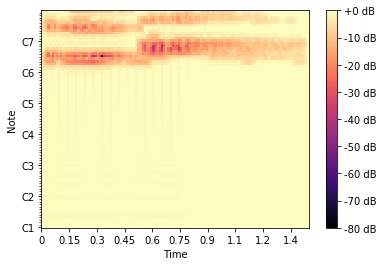

In [95]:

#smooth filter
# audio = medfilt(audio, 3)
# audio = butter_bandpass_filter(audio, 500, 5000,SR)
audio = np.array(audio)

soundfile.write('e:/Courses/mus270b/hw1/autosynth.wav', audio, SR)


cqt = librosa.amplitude_to_db(np.abs(librosa.cqt(audio, sr=sr)), ref=np.max)
librosa.display.specshow(librosa.amplitude_to_db(cqt, ref=np.max), sr=sr, x_axis='time', y_axis='cqt_note')
plt.colorbar(format='%+2.0f dB')
plt.show()

In [77]:
# Manual attempt!

track_len = int(SR*1.2)
track = np.zeros(track_len)
# note 1
note1 = np.zeros(track_len)
note1 += 41*librosa.core.tone(5749, sr=SR, length=track_len)
note1 += 37*librosa.core.tone(4436, sr=SR, length=track_len)
note1 += 86*librosa.core.tone(4278, sr=SR, length=track_len)
note1 += 155*librosa.core.tone(2791, sr=SR, length=track_len)
note1 += 110*librosa.core.tone(2632, sr=SR, length=track_len)
note1 += 264*librosa.core.tone(1479, sr=SR, length=track_len)
note1 += 150*librosa.core.tone(1316, sr=SR, length=track_len)
note1/=8192/4
# note 2
note2 = np.zeros(track_len)
note2 += 9*librosa.core.tone(4323, sr=SR, length=track_len)
note2 += 15*librosa.core.tone(3723, sr=SR, length=track_len)
note2 += 16*librosa.core.tone(2088, sr=SR, length=track_len)
note2 += 80*librosa.core.tone(1942, sr=SR, length=track_len)
note2 += 34*librosa.core.tone(1795, sr=SR, length=track_len)
note2 += 11*librosa.core.tone(1501, sr=SR, length=track_len)

note2/=8192/4

# temporal 1
temp1 = np.zeros(track_len)
for i in range(0, int(SR*0.3)):
    temp1[i] = 1
for i in range(int(SR*0.3), int(SR*0.4)):
    temp1[i] = (int(SR*0.4)-i)/int(SR*0.1)

# temporal 2
temp2 = np.zeros(track_len)
for i in range(int(SR*0.5), int(SR*0.8)):
    temp2[i] = 1
for i in range(int(SR*0.8), int(SR*1.1)):
    temp2[i] = (int(SR*1.1)-i)/int(SR*0.3)

track += temp1 * note1
track += temp2 * note2

soundfile.write('e:/Courses/mus270b/hw1/manual.wav', track, SR)


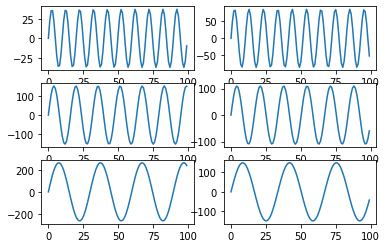

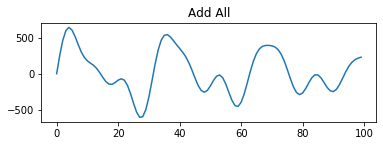

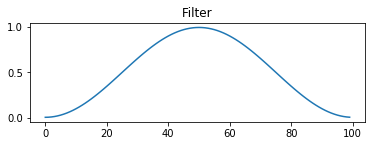

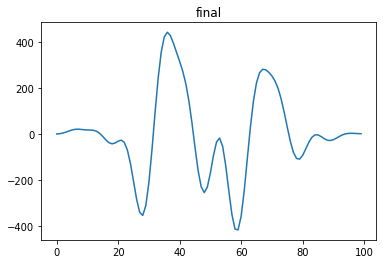

In [56]:
# Show Additive Synthesis
sr = 44100
tl = 100

shader = []
for i in range(tl):
    shader.append((1-0.99*math.cos(2*math.pi*i/tl))/2)
shader = np.array(shader)

sins = [
# 41*librosa.core.tone(5749, sr=SR, length=tl),
37*librosa.core.tone(4436, sr=SR, length=tl),
86*librosa.core.tone(4278, sr=SR, length=tl),
155*librosa.core.tone(2791, sr=SR, length=tl),
110*librosa.core.tone(2632, sr=SR, length=tl),
264*librosa.core.tone(1479, sr=SR, length=tl),
150*librosa.core.tone(1316, sr=SR, length=tl),
]
total = np.zeros(100)
for i, y in enumerate(sins):
    plt.subplot(3, 2, i+1)
    total+=y
    plt.plot(y)
plt.show()
plt.subplot(2,1,1)
plt.title('Add All')
plt.plot(total)
plt.show()
plt.subplot(2,1,2)
plt.title('Shader')
plt.plot(shader)
plt.show()
plt.subplot()
plt.title('Final')
plt.plot(shader*total)
plt.show()